# Detecting the COVID-19 cases from chest X-ray images. 
The machine learning-based model must detect whether the subject of study has been infected or not. 

**Data**
This dataset consists of 15264 (512x512) chest X-ray images for the train set and 400 images for the test set. The dataset contains positive and negative classes to indicate the positive and negative COVID-19 cases. You can find some examples of this dataset below:

***

Key Observations:
- Class_weight is not necessary
- Batch 16 vs Batch 32

# Initialize

In [2]:
### Connect with google drive
from google.colab import drive 
drive.mount('/content/drive')

from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow
tensorflow.random.set_seed(1)

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import trange
import os
import numpy as np


PATH = '/content/drive/MyDrive/DL_Project_2021'

Mounted at /content/drive


***

# Import metadata, train/valid splitting

In [3]:
### Import metadata (filename and its label)
label_df=pd.read_csv(PATH+'/train_labels.csv')
test_df=pd.read_csv(PATH+'/submission_file/sample_submission.csv')

### Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    label_df.File
    , label_df.Label
    , test_size=0.35
    , random_state=42
    , stratify=label_df.Label)

train_df = pd.DataFrame(X_train)
train_df['Label'] = y_train
valid_df = pd.DataFrame(X_test)
valid_df['Label'] = y_test

print( "All data    : ", label_df.Label.value_counts().to_dict())
print( "Traing set  : ", train_df.Label.value_counts().to_dict())
print( "Validation  : ", valid_df.Label.value_counts().to_dict())
print( "Testing set : ", test_df.Label.value_counts().to_dict())

All data    :  {0: 13694, 1: 1570}
Traing set  :  {0: 8901, 1: 1020}
Validation  :  {0: 4793, 1: 550}
Testing set :  {0: 400}


***

# Generate labeled dataset objects (ImageDataGenerator)
Generate labled dataset objects from a set of images on disk that is specified in a dataframe 

**Option 1:**
```python
tf.keras.preprocessing.image_dataset_from_directory
```
We have to separate your image files into folders for each class. The generator will take each folder as the classes to be trained.

**Option 2:** 

Use a dataframe to load data from the disk. This way it is more flexible, dataset could be in different places, i.e 
```
file1: base_path + '/folder1/1.jpg' 
file2: base_path + '/folder5/2.jpg' 
```

```python
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

train_df_3 = pd.read_csv("dataset3.csv")
train_df_3.columns = ['label','filename']
train_generator = datagen.flow_from_dataframe(dataframe=train_df_3,
                                              directory=base_path,
                                              x_col='filename',
                                              y_col="label")
```
In this option, we could retrieve **multiple labels** for the** multi-task problems**.
```python
train_generator = datagen.flow_from_dataframe(dataframe=train_df_3,
                                              directory=base_path,
                                              x_col='filename',
                                              y_col=["col1_dog_cat", "col2_skin_color"])
```

We should do the least possible amount of data-preprocessing before getting to the model so we don't need to perform the same preprocessing pipline with the new data. We can do this by include the processing pipeline into the model.
  - Normalization: For an image, each pixel consists of 3 integer values between 0 and 255 (RGB level values). We need to normalize the pixel values to be between -1 and 1.
  - Standardize to a fixed image size


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="File". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 9920 validated image filenames.
Found 5343 validated image filenames.
Found 400 validated image filenames.
Batch size            :  16
Lebel vector (1 batch):  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
Dimension of a sample :  (300, 300, 3)


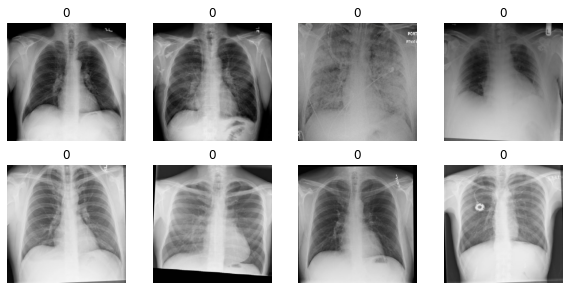

In [4]:
### Data Augmenetation
# rescale=1./255 => we would get an all-white images if we don't rescale
# batch_size: the smaller batch size tends to be faster
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# Training set: Rescaling and random rotation
datagen = ImageDataGenerator(rescale=1./255, rotation_range=3)
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df
    , directory=PATH + "/train/"
    , x_col="File"
    , y_col="Label"
    , class_mode="raw"
    , batch_size=16
    , shuffle=True
    , seed=1
    , target_size=(300,300))

# Validation and test set: Rescaling
datagen_test = ImageDataGenerator(rescale=1./255)
valid_generator = datagen_test.flow_from_dataframe(
    dataframe=valid_df
    , directory=PATH + "/train/"
    , x_col="File"
    , y_col="Label"
    , class_mode="raw"
    , batch_size=16
    , shuffle=False
    , seed=1
    , target_size=(300,300))
test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df
    , directory=PATH + "/test/"
    , x_col="File"
    , y_col="Label"
    , class_mode="raw"
    , batch_size=16
    , shuffle=False            # We don't shuffle the testing set
    , seed=1
    , target_size=(300,300))


### Visualize the images from the first batches
x, y = train_generator.__getitem__(1)
print ("Batch size            : ", len(x))
print ("Lebel vector (1 batch): ", y)
print ("Dimension of a sample : ", x[0].shape)

plt.figure(figsize=(10, 10))
for i, image in enumerate(x[0:8]):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(int(y[i]))
    plt.axis("off")

***

# Pre-Modeling: Metrics / Weights / Step sizes (batches)

In [5]:
#######################################
### Weights
weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.labels), train_generator.labels)
class_weight_dict = dict(enumerate(weights))
print ("class weighted:", class_weight_dict)


#######################################
### Step size for training and validation set
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
print ("Number of validation batches: ", STEP_SIZE_VALID, " Total sample: ", STEP_SIZE_VALID * train_generator.batch_size)
print ("Number of training batches:   ", STEP_SIZE_TRAIN, " Total sample: ", STEP_SIZE_TRAIN * valid_generator.batch_size)
print ("Number of testing batches:   ", STEP_SIZE_TEST, " Total sample: ", STEP_SIZE_TEST * test_generator.batch_size)
print ("Training size: ", len(train_df))
print ("Validation size: ", len(valid_df))
print ("Test size: ", len(test_df))

class weighted: {0: 0.5573033707865168, 1: 4.862745098039215}
Number of validation batches:  333  Total sample:  5328
Number of training batches:    620  Total sample:  9920
Number of testing batches:    25  Total sample:  400
Training size:  9921
Validation size:  5343
Test size:  400


**F1 metric:**

Option 1: via compile method
- https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
- https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

Option 2: via callbacks

The F1 score metric is only meaningful for the whole dataset so we need to create custom keras callbacks for f1-macro calculation.

`on_train_begin` is initialized at the beginning of the training. Here we initiate a list to hold the values, which are computed in `on_epoch_end`.

Reference: https://androidkt.com/calculate-f1-macro-in-keras/


**Precision and Recall**

ROC / AUC is the same criteria and the PR (Precision-Recall) curve (F1-score, Precision, Recall) is also the same criteria.

Real data will tend to have an imbalance between positive and negative samples. This imbalance has large effect on PR but not ROC/AUC.

So in the real world, the PR curve is used more since positive and negative samples are very uneven. The ROC/AUC curve does not reflect the performance of the classifier, but the PR curve can.


In [6]:
### Option 2: F1-metric via callback
class MetricsCallback(keras.callbacks.Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()

    def  on_train_begin(self,logs={}):
      self.f1_macro=[]

    def on_epoch_end(self, epoch, logs=None):
      # y_pred=self.model.predict(x_test).round()

      predict = model.predict_generator(valid_generator, steps = STEP_SIZE_VALID+1)
      predict[predict >= 0.5] = 1
      predict[predict < 0.5] = 0
      
      y_pred = predict
      y_true = valid_df.Label
      score = f1_score(y_true, y_pred, average='macro')
      self.f1_macro.append(score)
      print(" F1 macro :",score)

f1_metrics = MetricsCallback()

***

# Build a model: class_weight / steps_per_epoch / BinaryCrossentropy Loss

**Result** F1 score: {0:.98, 1:0.87, Macro:0.93, Acc:0.97}

**Freeze and Unfreeze**
1. Train the top layer (freeze the base model): 
We make sure to pass training=False when calling the base model, so that it runs in inference mode, so that **batchnorm statistics don't get updated** even after we unfreeze the base model for fine-tuning.

2. Fine-tuning of the entire model: 
We unfreeze the base model and train the entire model end-to-end with a low learning rate. Since the `trainin=False`, the model is still running in inference mode. This means that the statistics in batch normalization layer won't be updated. 

In [ ]:
### Loading the base model
# https://keras.io/api/applications/ : ResNet152V2 , InceptionResNetV2 , DenseNet201

base_model = keras.applications.Xception(
    weights='imagenet'         # Load weights pre-trained on ImageNet.
    , input_shape=(300,300,3)  # x[0].shape
    , include_top=False)       # Do not include the ImageNet classifier at the top.
base_model.trainable = False   # Freeze the base_model

### Normalization layer: output = (input-mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

### Create the model
inputs = keras.Input(shape=(300, 300, 3))
x = norm_layer(inputs)
x = base_model(x, training=False)               # base_model is running in inference mode here
x = keras.layers.GlobalAveragePooling2D()(x)    # 
x = keras.layers.Dropout(0.2)(x)                # add a Dropout layer before the classification layer, for regularization.
outputs = keras.layers.Dense(1, activation='sigmoid')(x) # sigmoid: ranging from 0 to 1, but need not sum to 1
model = keras.Model(inputs, outputs)

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 300, 300, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,536
Trainable params: 2,049
Non-trainable

**Training the top layer:**
- Optimization: Adam with weight decay
- metrics: binary accuracy, f1-score, f1-score (Callback)
- class_weight: weight from each class

**Note:** There is no need to run too many epoch. 5 epochs should be enough. In FastAI, the new layer was trained for only 1 epoch.

In [ ]:
init_lr = 0.01
num_epochs = 40

# Metrics: https://stackoverflow.com/questions/63016353/custom-keras-metric-functions-recall-precision-f1-score-isnt-enabling-the-l
model.compile(optimizer=keras.optimizers.Adam(lr=init_lr, decay=init_lr / num_epochs)
              , loss=keras.losses.BinaryCrossentropy()
              , metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(name='auc')])

es = EarlyStopping(monitor='val_binary_accuracy', mode='max'
                  , verbose=1, patience=15, restore_best_weights=True)
mc = ModelCheckpoint(PATH+'/model/keras_Xception.weighed_model.{epoch:02d}-{val_loss:.2f}.h5'
                    , monitor='val_binary_accuracy', mode='max'
                    , verbose=1, save_best_only=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', factor=0.2,patience=5, min_lr=0.001)

history = model.fit_generator(
    generator=train_generator
    , validation_data=valid_generator
    , steps_per_epoch=STEP_SIZE_TRAIN+1
    , validation_steps=STEP_SIZE_VALID+1
    , epochs=num_epochs
    , class_weight = class_weight_dict
    , callbacks=[es, mc, f1_metrics])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
621/621 [==============================] - 259s 413ms/step - loss: 0.2908 - binary_accuracy: 0.8904 - auc: 0.9524 - val_loss: 0.1499 - val_binary_accuracy: 0.9483 - val_auc: 0.9578

Epoch 00001: val_binary_accuracy improved from -inf to 0.94834, saving model to /content/drive/MyDrive/DL_Project_2021/model/keras_Xception.weighed_model.01-0.15.h5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 F1 macro : 0.866142249752194
Epoch 2/40
621/621 [==============================] - 256s 412ms/step - loss: 0.2576 - binary_accuracy: 0.9030 - auc: 0.9637 - val_loss: 0.3458 - val_binary_accuracy: 0.8611 - val_auc: 0.9635

Epoch 00002: val_binary_accuracy did not improve from 0.94834
 F1 macro : 0.7496906257844846
Epoch 3/40
621/621 [==============================] - 255s 411ms/step - loss: 0.2318 - binary_accuracy: 0.9061 - auc: 0.9673 - val_loss: 0.1555 - val_binary_accuracy: 0.9468 - val_auc: 0.9616

Epoch 00003: val_binary_accuracy did not improve from 0.94834
 F1 macro : 0.8649235587687364
Epoch 4/40
621/621 [==============================] - 253s 408ms/step - loss: 0.2153 - binary_accuracy: 0.9166 - auc: 0.9702 - val_loss: 0.1437 - val_binary_accuracy: 0.9506 - val_auc: 0.9639

Epoch 00004: val_binary_accuracy improved from 0.94834 to 0.95059, saving model to /content/drive/MyDrive/DL_Project_2021/model/keras_Xception.weighed_model.04-0.14.h5
 F1 macro : 0.8719621519368812
Epoch 

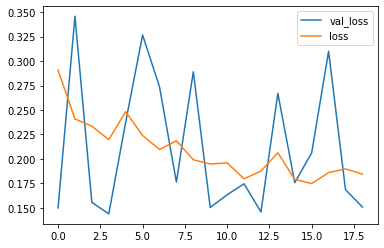

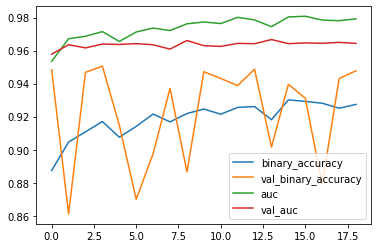

In [ ]:
pd.DataFrame(history.history)[['val_loss','loss']].plot()
pd.DataFrame(history.history)[['binary_accuracy', 'val_binary_accuracy','auc','val_auc']].plot()

In [ ]:
predict = model.predict_generator(valid_generator, steps = STEP_SIZE_VALID+1)
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
      
y_pred = predict
y_true = valid_df.Label

from sklearn.metrics import classification_report
print (confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[4633  160]
 [ 104  446]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4793
           1       0.74      0.81      0.77       550

    accuracy                           0.95      5343
   macro avg       0.86      0.89      0.87      5343
weighted avg       0.95      0.95      0.95      5343



## Train the whole model

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
normalization_3 (Normalizati (None, 300, 300, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 20,863,536
Trainable params: 20,809,001
Non-trainable params: 54,535
__________________________________________

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5)  # Low learning rate
    , loss=keras.losses.BinaryCrossentropy()
    , metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(name='auc')]
)

es = EarlyStopping(
    monitor='val_binary_accuracy'
    , mode='max'
    , verbose=1
    , patience=20
    , restore_best_weights=True)
mc = ModelCheckpoint(
    PATH+'/model/keras_Xception.weighed_model_all_model.{epoch:02d}-{val_binary_accuracy:.2f}.h5'
    , monitor='val_binary_accuracy'
    , mode='max'
    , verbose=1
    , save_best_only=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', factor=0.2,patience=5, min_lr=0.001)

history_full = model.fit_generator(
    generator=train_generator
    , validation_data=valid_generator
    , steps_per_epoch=STEP_SIZE_TRAIN+1
    , validation_steps=STEP_SIZE_VALID+1
    , epochs=50
    , class_weight = class_weight_dict
    , callbacks=[es, mc, f1_metrics])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
621/621 [==============================] - 274s 434ms/step - loss: 0.2181 - binary_accuracy: 0.9256 - auc: 0.9731 - val_loss: 0.1438 - val_binary_accuracy: 0.9515 - val_auc: 0.9795

Epoch 00001: val_binary_accuracy improved from -inf to 0.95153, saving model to /content/drive/MyDrive/DL_Project_2021/model/keras_Xception.weighed_model_all_model.01-0.14.h5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 F1 macro : 0.8822671684513714
Epoch 2/10
621/621 [==============================] - 261s 421ms/step - loss: 0.1279 - binary_accuracy: 0.9563 - auc: 0.9890 - val_loss: 0.1081 - val_binary_accuracy: 0.9676 - val_auc: 0.9855

Epoch 00002: val_binary_accuracy improved from 0.95153 to 0.96762, saving model to /content/drive/MyDrive/DL_Project_2021/model/keras_Xception.weighed_model_all_model.02-0.11.h5
 F1 macro : 0.918261898413987
Epoch 3/10
621/621 [==============================] - 262s 421ms/step - loss: 0.0810 - binary_accuracy: 0.9643 - auc: 0.9946 - val_loss: 0.1622 - val_binary_accuracy: 0.9452 - val_auc: 0.9875

Epoch 00003: val_binary_accuracy did not improve from 0.96762
 F1 macro : 0.8760251098609872
Epoch 4/10
621/621 [==============================] - 258s 415ms/step - loss: 0.0754 - binary_accuracy: 0.9708 - auc: 0.9923 - val_loss: 0.1587 - val_binary_accuracy: 0.9452 - val_auc: 0.9881

Epoch 00004: val_binary_accuracy did not improve from 0.96762
 F1 macro : 0.8766481041183

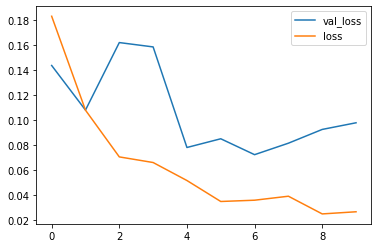

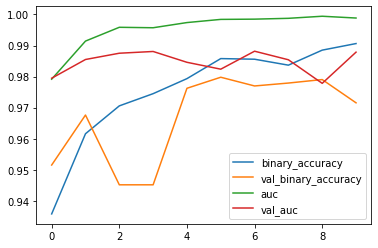

In [ ]:
pd.DataFrame(history_full.history)[['val_loss','loss']].plot()
pd.DataFrame(history_full.history)[['binary_accuracy', 'val_binary_accuracy','auc','val_auc']].plot()

In [ ]:
predict = model.predict_generator(valid_generator, steps = STEP_SIZE_VALID+1)
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
      
y_pred = predict
y_true = valid_df.Label

from sklearn.metrics import classification_report
print (confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[4670  123]
 [  29  521]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4793
           1       0.81      0.95      0.87       550

    accuracy                           0.97      5343
   macro avg       0.90      0.96      0.93      5343
weighted avg       0.97      0.97      0.97      5343



Prediction on testset

In [ ]:
predict = model.predict_generator(test_generator, steps = STEP_SIZE_TEST)

submission_keras = test_df.copy()
submission_keras['predict_prob'] = predict
submission_keras['File'] = test_generator.filenames
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
submission_keras['predict_class'] = [int(x[0]) for x in predict]

submission_keras.to_csv(PATH+'/submission_file/submission_ke_xcept_weight.csv', index=False)

submission_keras.predict_class.value_counts()

0    207
1    193
Name: predict_class, dtype: int64

***

# XCeption: BinaryCrossentropy / Class_weight

In [13]:
base_model = keras.applications.Xception(weights='imagenet', input_shape=(300,300,3), include_top=False)      
base_model.trainable = False  

### Normalization layer: output = (input-mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

### Create the model
inputs = keras.Input(shape=(300, 300, 3))
x = norm_layer(inputs)
x = base_model(x, training=False)              
x = keras.layers.GlobalAveragePooling2D()(x)   
x = keras.layers.Dropout(0.2)(x)               
outputs = keras.layers.Dense(1, activation='sigmoid')(x) 
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
normalization_2 (Normalizati (None, 300, 300, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 20,863,536
Trainable params: 2,049
Non-trainable params: 20,861,487
___________________________________________

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam()
    , loss=keras.losses.BinaryCrossentropy()
    , metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(name='auc')]
)

es = EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

history = model.fit_generator(generator=train_generator, validation_data=valid_generator    
    , steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, class_weight = class_weight_dict,
    , epochs=5, callbacks=[es])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
620/620 [==============================] - 330s 528ms/step - loss: 0.1878 - binary_accuracy: 0.9306 - auc: 0.9286 - val_loss: 0.1653 - val_binary_accuracy: 0.9352 - val_auc: 0.9422

Epoch 00001: val_binary_accuracy improved from -inf to 0.93525, saving model to /content/drive/MyDrive/DL_Project_2021/model/keras_Xception.weighed_model.01-0.17.h5
Epoch 2/5
620/620 [==============================] - 259s 417ms/step - loss: 0.1593 - binary_accuracy: 0.9389 - auc: 0.9476 - val_loss: 0.1517 - val_binary_accuracy: 0.9450 - val_auc: 0.9496

Epoch 00002: val_binary_accuracy improved from 0.93525 to 0.94501, saving model to /content/drive/MyDrive/DL_Project_2021/model/keras_Xception.weighed_model.02-0.15.h5
Epoch 3/5
620/620 [==============================] - 258s 417ms/step - loss: 0.1427 - binary_accuracy: 0.9470 - auc: 0.9608 - val_loss: 0.1494 - val_binary_accuracy: 0.9435 - val_auc: 0.9518

Epoch 00003: val_binary_accuracy did not improve from 0.94501
Epoch 4/5
620/620 [==========

In [23]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-4)  # Low learning rate
    , loss=keras.losses.BinaryCrossentropy()
    , metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(name='auc')]
)

es = EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=20, restore_best_weights=True)

history_full = model.fit_generator(generator=train_generator, validation_data=valid_generator
    , steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID
    , epochs=50, class_weight = class_weight_dict, callbacks=[es])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
normalization_2 (Normalizati (None, 300, 300, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 20,863,536
Trainable params: 20,809,001
Non-trainable params: 54,535
__________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
620/620 [==============================] - 275s 436ms/step - loss: 0.1065 - binary_accuracy: 0.9646 - auc: 0.9922 - val_loss: 0.0835 - val_binary_accuracy: 0.9696 - val_auc: 0.9879
Epoch 2/50
620/620 [==============================] - 269s 433ms/step - loss: 0.1906 - binary_accuracy: 0.9497 - auc: 0.9831 - val_loss: 0.1544 - val_binary_accuracy: 0.9538 - val_auc: 0.9927
Epoch 3/50
620/620 [==============================] - 266s 429ms/step - loss: 0.0723 - binary_accuracy: 0.9719 - auc: 0.9960 - val_loss: 0.1034 - val_binary_accuracy: 0.9718 - val_auc: 0.9897
Epoch 4/50
620/620 [==============================] - 269s 433ms/step - loss: 0.0677 - binary_accuracy: 0.9748 - auc: 0.9962 - val_loss: 0.0733 - val_binary_accuracy: 0.9799 - val_auc: 0.9931
Epoch 5/50
620/620 [==============================] - 268s 432ms/step - loss: 0.0407 - binary_accuracy: 0.9817 - auc: 0.9984 - val_loss: 0.0677 - val_binary_accuracy: 0.9786 - val_auc: 0.9894
Epoch 6/50
620/620 [====================

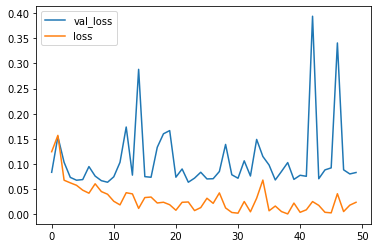

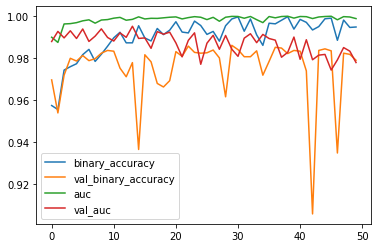

In [24]:
pd.DataFrame(history_full.history)[['val_loss','loss']].plot()
pd.DataFrame(history_full.history)[['binary_accuracy', 'val_binary_accuracy','auc','val_auc']].plot()

In [27]:
predict = model.predict_generator(valid_generator, steps = STEP_SIZE_VALID+1)
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
      
y_pred = predict
y_true = valid_df.Label

print (confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[4756   37]
 [  38  512]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4793
           1       0.93      0.93      0.93       550

    accuracy                           0.99      5343
   macro avg       0.96      0.96      0.96      5343
weighted avg       0.99      0.99      0.99      5343



In [28]:
predict = model.predict_generator(test_generator, steps = STEP_SIZE_TEST)

submission_keras = test_df.copy()
submission_keras['predict_prob'] = predict
submission_keras['File'] = test_generator.filenames
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
submission_keras['predict_class'] = [int(x[0]) for x in predict]

submission_keras.to_csv(PATH+'/submission_file/submission_ke_densenet201_weight.csv', index=False)

submission_keras.predict_class.value_counts()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0    211
1    189
Name: predict_class, dtype: int64

***

## XCeption No-class_weight / BinaryCrossentropy

In [31]:
base_model = keras.applications.Xception(weights='imagenet', input_shape=(300,300,3), include_top=False)      
base_model.trainable = False  

### Normalization layer: output = (input-mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

### Create the model
inputs = keras.Input(shape=(300, 300, 3))
x = norm_layer(inputs)
x = base_model(x, training=False)              
x = keras.layers.GlobalAveragePooling2D()(x)   
x = keras.layers.Dropout(0.2)(x)               
outputs = keras.layers.Dense(1, activation='sigmoid')(x) 
model = keras.Model(inputs, outputs)


model.compile(
    optimizer=keras.optimizers.Adam()
    , loss=keras.losses.BinaryCrossentropy()
    , metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(name='auc')]
)

es = EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

history = model.fit_generator(generator=train_generator, validation_data=valid_generator    
    , steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID
    , epochs=5, callbacks=[es])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
620/620 [==============================] - 264s 422ms/step - loss: 0.2899 - binary_accuracy: 0.8828 - auc: 0.7919 - val_loss: 0.1926 - val_binary_accuracy: 0.9360 - val_auc: 0.9221
Epoch 2/5
620/620 [==============================] - 262s 422ms/step - loss: 0.1793 - binary_accuracy: 0.9293 - auc: 0.9399 - val_loss: 0.1641 - val_binary_accuracy: 0.9398 - val_auc: 0.9394
Epoch 3/5
620/620 [==============================] - 262s 422ms/step - loss: 0.1630 - binary_accuracy: 0.9398 - auc: 0.9493 - val_loss: 0.1592 - val_binary_accuracy: 0.9386 - val_auc: 0.9468
Epoch 4/5
620/620 [==============================] - 261s 421ms/step - loss: 0.1501 - binary_accuracy: 0.9440 - auc: 0.9557 - val_loss: 0.1464 - val_binary_accuracy: 0.9459 - val_auc: 0.9519
Epoch 5/5
620/620 [==============================] - 262s 422ms/step - loss: 0.1435 - binary_accuracy: 0.9438 - auc: 0.9584 - val_loss: 0.1416 - val_binary_accuracy: 0.9521 - val_auc: 0.9545


In [32]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-4)  # Low learning rate
    , loss=keras.losses.BinaryCrossentropy()
    , metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(name='auc')]
)

es = EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=20, restore_best_weights=True)

history_full = model.fit_generator(generator=train_generator, validation_data=valid_generator
    , steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID
    , epochs=50, callbacks=[es])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
620/620 [==============================] - 274s 435ms/step - loss: 0.1887 - binary_accuracy: 0.9340 - auc: 0.9144 - val_loss: 0.0759 - val_binary_accuracy: 0.9726 - val_auc: 0.9890
Epoch 2/50
620/620 [==============================] - 268s 433ms/step - loss: 0.0723 - binary_accuracy: 0.9743 - auc: 0.9893 - val_loss: 0.1027 - val_binary_accuracy: 0.9685 - val_auc: 0.9756
Epoch 3/50
620/620 [==============================] - 267s 430ms/step - loss: 0.0494 - binary_accuracy: 0.9826 - auc: 0.9908 - val_loss: 0.0607 - val_binary_accuracy: 0.9825 - val_auc: 0.9858
Epoch 4/50
620/620 [==============================] - 267s 430ms/step - loss: 0.0417 - binary_accuracy: 0.9854 - auc: 0.9931 - val_loss: 0.0699 - val_binary_accuracy: 0.9745 - val_auc: 0.9890
Epoch 5/50
620/620 [==============================] - 266s 429ms/step - loss: 0.0312 - binary_accuracy: 0.9888 - auc: 0.9963 - val_loss: 0.0829 - val_binary_accuracy: 0.9754 - val_auc: 0.9926
Epoch 6/50
620/620 [====================

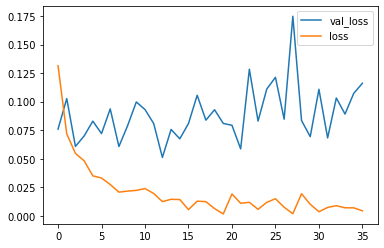

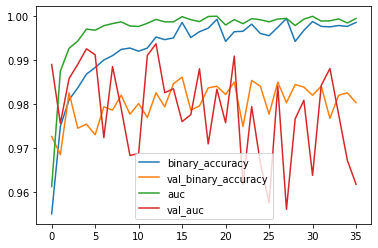

In [33]:
pd.DataFrame(history_full.history)[['val_loss','loss']].plot()
pd.DataFrame(history_full.history)[['binary_accuracy', 'val_binary_accuracy','auc','val_auc']].plot()

In [34]:
predict = model.predict_generator(valid_generator, steps = STEP_SIZE_VALID+1)
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
      
y_pred = predict
y_true = valid_df.Label

print (confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[4766   27]
 [  48  502]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4793
           1       0.95      0.91      0.93       550

    accuracy                           0.99      5343
   macro avg       0.97      0.95      0.96      5343
weighted avg       0.99      0.99      0.99      5343



In [36]:
predict = model.predict_generator(test_generator, steps = STEP_SIZE_TEST)

submission_keras = test_df.copy()
submission_keras['predict_prob'] = predict
submission_keras['File'] = test_generator.filenames
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
submission_keras['predict_class'] = [int(x[0]) for x in predict]

submission_keras.to_csv(PATH+'/submission_file/submission_ke_densenet201_unweight.csv', index=False)

submission_keras.predict_class.value_counts()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0    216
1    184
Name: predict_class, dtype: int64

# XCeption: batch_size=32 

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="File". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 9920 validated image filenames.
Found 5343 validated image filenames.
Found 400 validated image filenames.
Batch size            :  32
Lebel vector (1 batch):  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Dimension of a sample :  (300, 300, 3)


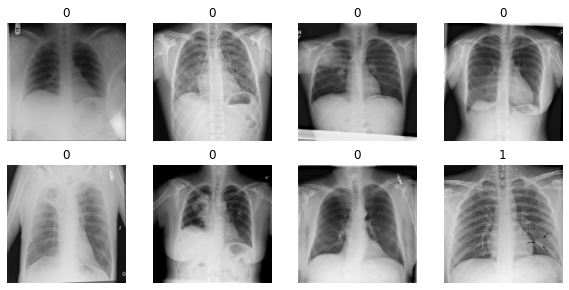

In [4]:
### Data Augmenetation
# rescale=1./255 => we would get an all-white images if we don't rescale
# batch_size: the smaller batch size tends to be faster
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# Training set: Rescaling and random rotation
datagen = ImageDataGenerator(rescale=1./255, rotation_range=3)
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df
    , directory=PATH + "/train/"
    , x_col="File"
    , y_col="Label"
    , class_mode="raw"
    , batch_size=32
    , shuffle=True
    , seed=1
    , target_size=(300,300))

# Validation and test set: Rescaling
datagen_test = ImageDataGenerator(rescale=1./255)
valid_generator = datagen_test.flow_from_dataframe(
    dataframe=valid_df
    , directory=PATH + "/train/"
    , x_col="File"
    , y_col="Label"
    , class_mode="raw"
    , batch_size=32
    , shuffle=False
    , seed=1
    , target_size=(300,300))
test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df
    , directory=PATH + "/test/"
    , x_col="File"
    , y_col="Label"
    , class_mode="raw"
    , batch_size=32
    , shuffle=False           
    , seed=1
    , target_size=(300,300))


### Visualize the images from the first batches
x, y = train_generator.__getitem__(1)
print ("Batch size            : ", len(x))
print ("Lebel vector (1 batch): ", y)
print ("Dimension of a sample : ", x[0].shape)

plt.figure(figsize=(10, 10))
for i, image in enumerate(x[0:8]):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(int(y[i]))
    plt.axis("off")

In [5]:
#######################################
### Step size for training and validation set
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST  = test_generator.n//test_generator.batch_size
print ("Number of validation batches: ", STEP_SIZE_VALID, " Total sample: ", STEP_SIZE_VALID * train_generator.batch_size)
print ("Number of training batches:   ", STEP_SIZE_TRAIN, " Total sample: ", STEP_SIZE_TRAIN * valid_generator.batch_size)
print ("Number of testing batches:   ", STEP_SIZE_TEST, " Total sample: ", STEP_SIZE_TEST * test_generator.batch_size)
print ("Training size: ", len(train_df))
print ("Validation size: ", len(valid_df))
print ("Test size: ", len(test_df))

Number of validation batches:  166  Total sample:  5312
Number of training batches:    310  Total sample:  9920
Number of testing batches:    12  Total sample:  384
Training size:  9921
Validation size:  5343
Test size:  400


Testing size +1

In [6]:
base_model = keras.applications.Xception(weights='imagenet', input_shape=(300,300,3), include_top=False)      
base_model.trainable = False  

### Normalization layer: output = (input-mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

### Create the model
inputs = keras.Input(shape=(300, 300, 3))
x = norm_layer(inputs)
x = base_model(x, training=False)              
x = keras.layers.GlobalAveragePooling2D()(x)   
x = keras.layers.Dropout(0.2)(x)               
outputs = keras.layers.Dense(1, activation='sigmoid')(x) 
model = keras.Model(inputs, outputs)


model.compile(
    optimizer=keras.optimizers.Adam()
    , loss=keras.losses.BinaryCrossentropy()
    , metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(name='auc')]
)

es = EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

history = model.fit_generator(generator=train_generator, validation_data=valid_generator    
    , steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID
    , epochs=5, callbacks=[es])

83689472/83683744 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
310/310 [==============================] - 3694s 12s/step - loss: 0.3067 - binary_accuracy: 0.8806 - auc: 0.7548 - val_loss: 0.2061 - val_binary_accuracy: 0.9207 - val_auc: 0.9137
Epoch 2/5
310/310 [==============================] - 245s 789ms/step - loss: 0.1987 - binary_accuracy: 0.9237 - auc: 0.9188 - val_loss: 0.1818 - val_binary_accuracy: 0.9307 - val_auc: 0.9310
Epoch 3/5
310/310 [==============================] - 244s 787ms/step - loss: 0.1685 - binary_accuracy: 0.9407 - auc: 0.9415 - val_loss: 0.1657 - val_binary_accuracy: 0.9430 - val_auc: 0.9397
Epoch 4/5
310/310 [==============================] - 245s 789ms/step - loss: 0.1625 - binary_accuracy: 0.9397 - auc: 0.9486 - val_loss: 0.1564 - val_binary_accuracy: 0.9411 - val_auc: 0.9458
Epoch 5/5
310/310 [==============================] - 244s 787ms/step - loss: 0.1532 - binary_accuracy: 0.9431 - auc: 0.9562 - val_loss: 0.1499 - val_binary_accuracy: 0.9452 - val_auc: 0.9490


In [7]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-4)  # Low learning rate
    , loss=keras.losses.BinaryCrossentropy()
    , metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(name='auc')]
)

es = EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

history_full = model.fit_generator(generator=train_generator, validation_data=valid_generator
    , steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID
    , epochs=50, callbacks=[es])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
310/310 [==============================] - 274s 868ms/step - loss: 0.1487 - binary_accuracy: 0.9468 - auc: 0.9443 - val_loss: 0.0753 - val_binary_accuracy: 0.9752 - val_auc: 0.9847
Epoch 2/50
310/310 [==============================] - 266s 857ms/step - loss: 0.0605 - binary_accuracy: 0.9784 - auc: 0.9936 - val_loss: 0.0551 - val_binary_accuracy: 0.9823 - val_auc: 0.9914
Epoch 3/50
310/310 [==============================] - 267s 860ms/step - loss: 0.0428 - binary_accuracy: 0.9846 - auc: 0.9963 - val_loss: 0.0571 - val_binary_accuracy: 0.9817 - val_auc: 0.9920
Epoch 4/50
310/310 [==============================] - 265s 855ms/step - loss: 0.0354 - binary_accuracy: 0.9871 - auc: 0.9964 - val_loss: 0.0511 - val_binary_accuracy: 0.9817 - val_auc: 0.9930
Epoch 5/50
310/310 [==============================] - 266s 857ms/step - loss: 0.0302 - binary_accuracy: 0.9886 - auc: 0.9972 - val_loss: 0.1044 - val_binary_accuracy: 0.9720 - val_auc: 0.9686
Epoch 6/50
310/310 [====================

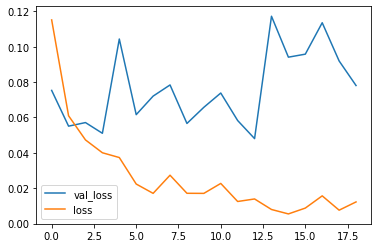

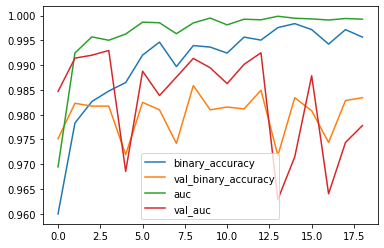

In [8]:
pd.DataFrame(history_full.history)[['val_loss','loss']].plot()
pd.DataFrame(history_full.history)[['binary_accuracy', 'val_binary_accuracy','auc','val_auc']].plot()

In [9]:
predict = model.predict_generator(valid_generator, steps = STEP_SIZE_VALID+1)
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
      
y_pred = predict
y_true = valid_df.Label

print (confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[4745   48]
 [  29  521]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4793
           1       0.92      0.95      0.93       550

    accuracy                           0.99      5343
   macro avg       0.95      0.97      0.96      5343
weighted avg       0.99      0.99      0.99      5343

